In [1]:
# # Running Python 3.10.13
# !pip install -r requirements.txt

In [2]:
from utils import *

from deltalake import DeltaTable
import pandas as pd
import gcsfs
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 4000)

from dotenv import load_dotenv
load_dotenv()

True

In [3]:

def get_gcp_creds_from_env():
    import json
    gcp_creds_encoded = os.environ.get("GCP_CREDENTIALS_JSON_ENCODED")
    gcp_credentials_json = JSON_EncoderDecoder(gcp_creds_encoded).decode().get()
    gcp_credentials_json_str = json.dumps(gcp_credentials_json)
    return gcp_credentials_json_str

# get_gcp_creds_from_env()

def get_date_from_lookback(lookback_days: int):
    from datetime import datetime, timedelta

    # Calculate the target date by subtracting the lookback_days from the current UTC date
    target_date = datetime.utcnow() - timedelta(days=lookback_days)
    # Extract year, month, and day
    year, month, day = target_date.year, target_date.month, target_date.day
    return f'{year}/{month:02d}/{day:02d}'


def read_data_preprocessed(table_path='gs://datalake-flight-dev-1/flightsummary-delta-processed-stream'):

    storage_options = {'service_account_key': get_gcp_creds_from_env()}

    dt = DeltaTable(table_path, storage_options=storage_options)
    
    start_date = get_date_from_lookback(lookback_days=365)
    print(f"Reading data from {start_date}")

    df = dt.to_pandas(partitions=[("crt_ts_date", ">=", start_date)])
    return df


In [4]:
def create_target(df):
    """
    Create a target variable for modelling. 
    The target is the number of minutes between the actual landing time and the event time.
    """

    # group by flight id to get all the landing times
    landing_times = df[['fa_flight_id','actual_in']].groupby('fa_flight_id').max()['actual_in']

    # fill in the landing times 
    df['actual_in_filled'] = df['fa_flight_id'].map(landing_times)
    
    # calculate target in minutes
    df['target'] = (df['actual_in_filled'] - df['event_ts']).dt.total_seconds() / 60
    
    # Color the target so we can see it better
    df.style.bar(subset=['target'], color='#d65f5f')
    
    # Sort based on the time which events are SUPPOSED to happened
    df = df.sort_values(by=['actual_in_filled','crt_ts'])
    return df

def remove_incomplete_flights(df):
    " Remove flights which don't have a landing time"
    return df[df['actual_in_filled'].notnull()]

def removed_arrival_events(df):
    " For modelling, we only want to look at events which happen before landing"
    return df[df['event_type'] != 'actual_in']

def style_datframe(df):
    def highlight_scheduled_out(row):
        if row['event_type'] == 'scheduled_out':
            return ['background-color: lightgreen; color: black'] * len(row)
        return [''] * len(row)

    # Apply the styling
    return df.style.apply(highlight_scheduled_out, axis=1)

    

In [5]:
df = read_data_preprocessed()

df.head()

Reading data from 2022/10/26


,ident,ident_icao,ident_iata,fa_flight_id,operator,operator_icao,operator_iata,flight_number,registration,atc_ident,inbound_fa_flight_id,codeshares,codeshares_iata,blocked,diverted,cancelled,position_only,departure_delay,arrival_delay,filed_ete,foresight_predictions_available,scheduled_out,estimated_out,actual_out,scheduled_off,estimated_off,actual_off,scheduled_on,estimated_on,actual_on,scheduled_in,estimated_in,actual_in,progress_percent,status,aircraft_type,route_distance,filed_airspeed,filed_altitude,route,baggage_claim,seats_cabin_business,seats_cabin_coach,seats_cabin_first,gate_origin,gate_destination,terminal_origin,terminal_destination,type,origin_code,origin_code_icao,origin_code_iata,origin_code_lid,origin_timezone,origin_name,origin_city,origin_airport_info_url,destination_code,destination_code_icao,destination_code_iata,destination_code_lid,destination_timezone,destination_name,destination_city,destination_airport_info_url,crt_ts,crt_ts_year,crt_ts_month,crt_ts_day,crt_ts_hour,last_run_ts,last_scheduled_out_ts,crt_ts_date,ingest_ts,event_type,event_ts
0,AAL2563,AAL2563,AA2563,AAL2563-1692612144-airline-186p,AAL,AAL,AA,2563,N806NN,None,AAL1324-1692576280-airline-1715p,[],[],False,False,False,False,-420,-420,2460,True,2023-08-23 10:00:00,2023-08-23 10:00:00,2023-08-23 09:53:00,2023-08-23 10:10:00,2023-08-23 10:22:58,2023-08-23 10:22:58,2023-08-23 10:51:00,2023-08-23 11:01:53,2023-08-23 11:01:53,2023-08-23 11:18:00,2023-08-23 11:11:00,NaT,100,Landed / Taxiing,B738,191,468,230.0,ELOEL3 FORSS GUTZZ BOOVE6,C26,None,None,None,30,C37,None,C,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-23 11:10:01,2023,8,23,11,2023-08-23 11:00:01,2023-08-23 10:00:00,2023-08-23,2023-10-26 04:25:45.321,actual_on,2023-08-23 11:01:53
1,AAL2563,AAL2563,AA2563,AAL2563-1692612144-airline-186p,AAL,AAL,AA,2563,N806NN,None,AAL1324-1692576280-airline-1715p,[],[],False,False,False,False,-420,-1020,2460,True,2023-08-23 10:00:00,2023-08-23 09:53:00,2023-08-23 09:53:00,2023-08-23 10:10:00,2023-08-23 10:10:00,NaT,2023-08-23 10:51:00,2023-08-23 10:51:00,NaT,2023-08-23 11:18:00,2023-08-23 11:01:00,NaT,0,Taxiing / Left Gate,B738,191,468,230.0,ELOEL3 FORSS GUTZZ BOOVE6,C26,None,None,None,30,C37,None,C,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-23 10:00:02,2023,8,23,10,2023-08-23 09:50:01,2023-08-23 10:00:00,2023-08-23,2023-10-26 04:24:47.779,actual_out,2023-08-23 09:53:00
2,AAL2563,AAL2563,AA2563,AAL2563-1692180209-airline-5757p,AAL,AAL,AA,2563,N838NN,None,AAL2707-1692150553-schedule-615p,[],[],False,False,False,False,-120,-960,2520,True,2023-08-18 10:00:00,2023-08-18 09:58:00,2023-08-18 09:58:00,2023-08-18 10:10:00,2023-08-18 10:10:00,NaT,2023-08-18 10:52:00,2023-08-18 10:52:00,NaT,2023-08-18 11:18:00,2023-08-18 11:02:00,NaT,0,Taxiing / Left Gate,B738,191,464,230.0,ELOEL3 FORSS GUTZZ BOOVE6,C25,None,None,None,22,C29,None,C,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-18 10:00:02,2023,8,18,10,2023-08-18 09:50:02,2023-08-18 10:00:00,2023-08-18,2023-10-26 02:50:01.063,actual_out,2023-08-18 09:58:00
3,AAL2563,AAL2563,AA2563,AAL2563-1692698624-airline-2681p,AAL,AAL,AA,2563,N926NN,None,AAL2707-1692668930-airline-764p,[],[],False,False,False,False,0,0,3480,False,2023-08-24 10:00:00,2023-08-24 10:00:00,NaT,2023-08-24 10:10:00,2023-08-24 10:10:00,NaT,2023-08-24 11:08:00,2023-08-24 11:08:00,NaT,2023-08-24 11:18:00,2023-08-24 11:18:00,NaT,0,Scheduled,B738,191,172,NaN,None,None,None,None,None,None,None,None,None,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas

In [6]:
# How can we improve read performance?

In [8]:
df = create_target(df)

df = remove_incomplete_flights(df)

df = removed_arrival_events(df)

style_datframe(df)


,ident,ident_icao,ident_iata,fa_flight_id,operator,operator_icao,operator_iata,flight_number,registration,atc_ident,inbound_fa_flight_id,codeshares,codeshares_iata,blocked,diverted,cancelled,position_only,departure_delay,arrival_delay,filed_ete,foresight_predictions_available,scheduled_out,estimated_out,actual_out,scheduled_off,estimated_off,actual_off,scheduled_on,estimated_on,actual_on,scheduled_in,estimated_in,actual_in,progress_percent,status,aircraft_type,route_distance,filed_airspeed,filed_altitude,route,baggage_claim,seats_cabin_business,seats_cabin_coach,seats_cabin_first,gate_origin,gate_destination,terminal_origin,terminal_destination,type,origin_code,origin_code_icao,origin_code_iata,origin_code_lid,origin_timezone,origin_name,origin_city,origin_airport_info_url,destination_code,destination_code_icao,destination_code_iata,destination_code_lid,destination_timezone,destination_name,destination_city,destination_airport_info_url,crt_ts,crt_ts_year,crt_ts_month,crt_ts_day,crt_ts_hour,last_run_ts,last_scheduled_out_ts,crt_ts_date,ingest_ts,event_type,event_ts,actual_in_filled,target
42,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,None,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:16:34,2023-08-08 12:52:00,2023-08-08 12:56:18,2023-08-08 12:56:18,2023-08-08 13:12:00,2023-08-08 13:07:00,2023-08-08 13:15:00,100,Arrived / Gate Arrival,A319,191,482,230.000000,ELOEL3 FORSS GUTZZ BOOVE6,B5,None,None,None,22,B12,None,B,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-14 18:50:01,2023,8,14,18,2000-01-01 00:00:00,None,2023-08-14,2023-10-26 01:35:02.524000,scheduled_out,2023-08-08 12:00:00,2023-08-08 13:15:00,75.000000
43,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,None,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:16:34,2023-08-08 12:52:00,2023-08-08 12:56:18,2023-08-08 12:56:18,2023-08-08 13:12:00,2023-08-08 13:07:00,2023-08-08 13:15:00,100,Arrived / Gate Arrival,A319,191,482,230.000000,ELOEL3 FORSS GUTZZ BOOVE6,B5,None,None,None,22,B12,None,B,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-14 18:50:01,2023,8,14,18,2000-01-01 00:00:00,None,2023-08-14,2023-10-26 01:35:02.524000,actual_out,2023-08-08 11:54:00,2023-08-08 13:15:00,81.000000
44,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,None,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:16:34,2023-08-08 12:52:00,2023-08-08 12:56:18,2023-08-08 12:56:18,2023-08-08 13:12:00,2023-08-08 13:07:00,2023-08-08 13:15:00,100,Arrived / Gate Arrival,A319,191,482,230.000000,ELOEL3 FORSS GUTZZ BOOVE6,B5,None,None,None,22,B12,None,B,Airline,KAUS,KAUS,AUS,AUS,America/Chicago,Austin-Bergstrom Intl,Austin,/airports/KAUS,KDFW,KDFW,DFW,DFW,America/Chicago,Dallas-Fort Worth Intl,Dallas-Fort Worth,/airports/KDFW,2023-08-14 18:50:01,2023,8,14,18,2000-01-01 00:00:00,None,2023-08-14,2023-10-26 01:35:02.524000,actual_off,2023-08-08 12:16:34,2023-08-08 13:15:00,58.433333
45,AAL2563,AAL2563,AA2563,AAL2563-1691323529-airline-902p,AAL,AAL,AA,2563,N9016,None,AAL1586-1691257539-airline-213p,['JAL7235'],['JL7235'],False,False,False,False,-360,180,2520,True,2023-08-08 12:00:00,2023-08-08 11:54:00,2023-08-08 11:54:00,2023-08-08 12:10:00,2023-08-08 12:16:34,2023-08-08 12:

In [6]:
df.to_parquet('data/flights_processed_model_ready.parquet', engine='pyarrow')
df.to_csv('data/flights_processed_model_ready.csv', index=False)

In [148]:
NUM_FEATURES = ['filed_airspeed']
CAT_FEATURES = ['event_type']
# CAT_FEATURES += ['gate_origin','gate_destination','terminal_destination']
DATE_FEATURES = ['event_ts']
TARGET = 'target'
KFOLD_GROUP = 'fa_flight_id'

ALL_COLS = DATE_FEATURES+CAT_FEATURES+NUM_FEATURES+[TARGET]+[KFOLD_GROUP]

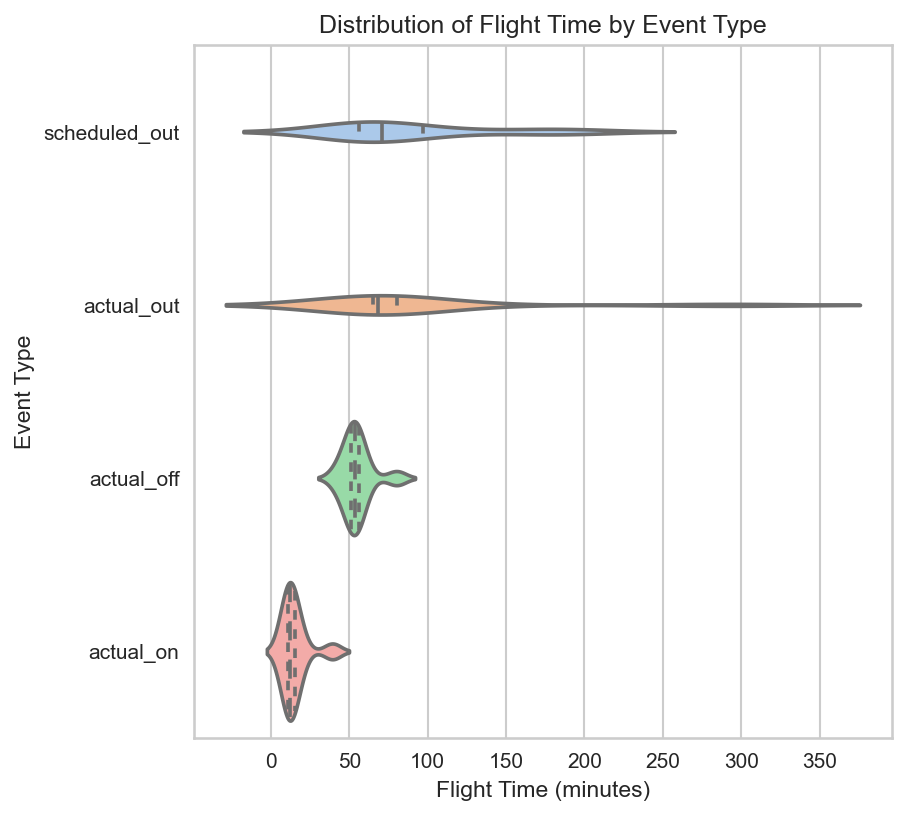

In [149]:
def plot_target_distribution(df, type='violin'):
    
    if type == 'violin':
        # Plotting the distribution of flight time by event type, with individual vertical plots
        plt.figure(figsize=(6, 6), dpi=150)
        sns.violinplot(data=df, y='event_type', x='target', inner='quartile', palette='pastel')
        plt.title('Distribution of Flight Time by Event Type')
        plt.ylabel('Event Type')
        plt.xlabel('Flight Time (minutes)')
        plt.show()

    if type == 'boxplot':
        plt.figure(figsize=(10, 12))
        sns.boxplot(data=df, y='event_type', x='target', palette='pastel')
        plt.title('Distribution of Flight Time by Event Type')
        plt.ylabel('Event Type')
        plt.xlabel('Flight Time (minutes)')
        plt.show()
        
        
plot_target_distribution(df)

In [151]:
# df = df[df['target'] < 300]

In [152]:
df[ALL_COLS].dtypes

event_ts          datetime64[ns]
event_type                object
filed_airspeed             int64
target                   float64
fa_flight_id              object
dtype: object

In [153]:
from pycaret.regression import *
ml_exp = setup(data=df[ALL_COLS], 
      target='target', 
      session_id=123, 
      # preprocess=True, 
      # custom_pipeline=[preprocessor],
      numeric_features = NUM_FEATURES,
      categorical_features = CAT_FEATURES,
      date_features = DATE_FEATURES,
      ignore_features = 'fa_flight_id',
      create_date_columns = ['hour','dayofweek'],
      outliers_threshold = 0.05,
      # feature_selection = True,
      # feature_selection_method = 'univariate',
      fold_strategy="groupkfold", 
      fold_groups= KFOLD_GROUP,
      # pca=True
      )


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(43, 5)"
4,Transformed data shape,"(43, 8)"
5,Transformed train set shape,"(30, 8)"
6,Transformed test set shape,"(13, 8)"
7,Ignore features,12
8,Numeric features,1
9,Date features,1


In [154]:
# lr = create_model('lr')

In [162]:
best_model = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,13.4527,647.7640,17.5515,-4.5321,0.2977,0.2464,0.1080
lar,Least Angle Regression,16.0963,604.8439,20.5395,-1.3040,0.5538,0.4125,0.1200
rf,Random Forest Regressor,18.8452,1003.3314,23.6036,-6.2701,0.3576,0.3558,0.1130
gbr,Gradient Boosting Regressor,18.9296,1069.9346,23.7907,-3.0634,0.3701,0.3688,0.1150
ridge,Ridge Regression,19.0647,894.0617,23.8357,-4.0533,0.4541,0.4669,0.1120
lasso,Lasso Regression,18.7434,926.0812,24.0063,-4.5204,0.4529,0.4240,0.1150
llar,Lasso Least Angle Regression,18.7434,926.0941,24.0065,-4.5206,0.4529,0.4240,0.1080
lr,Linear Regression,19.5756,907.7791,24.6950,-3.2805,0.5261,0.4525,0.1170
et,Extra Trees Regressor,19.1909,1049.6545,25.3527,-8.5058,0.3674,0.3486,0.1160
ada,AdaBoost Regressor,19.4924,1287.9780,26.8042,-9.7432,0.3692,0.3470,0.1140


In [163]:
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.9772,51.5138,7.1773,0.8734,0.2007,0.2065
1,11.2301,140.4319,11.8504,0.7176,0.3901,0.2713
2,14.9500,384.2370,19.6020,-0.1948,0.3381,0.3835
3,43.7336,4624.6735,68.0050,0.1997,0.5827,0.4093
4,2.5221,8.5894,2.9308,0.9849,0.1232,0.1094
5,8.1106,81.0579,9.0032,0.8548,0.5623,0.2824
6,4.5668,35.6001,5.9666,0.8839,0.2912,0.2868
7,1.9121,4.0185,2.0046,0.8865,0.0384,0.0371
8,27.6863,778.1215,27.8948,-47.6326,0.3346,0.2815


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [164]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [165]:
final_model = finalize_model(tuned_model)
final_model

Pipeline(memory=FastMemory(location=/var/folders/h9/5tcwr7tj1bz4bkm47lrggkhm0000gn/T/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['event_ts'],
                                    transformer=ExtractDateTimeFeatures(features=['hour',
                                                                                  'dayofweek']))),
                ('numerical_imputer',
                 TransformerWrapper(include=['filed_airspeed'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['event_type'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['event_type'],
                                    transformer=OneHotEncoder(cols=['event_type'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator', HuberRegressor(fit_intercept=False))])

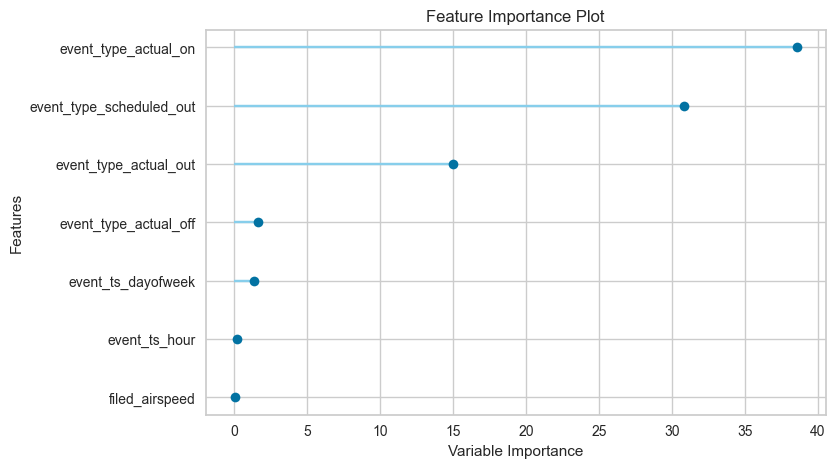

In [166]:
plot_model(tuned_model, plot = 'feature')


In [167]:
# deep_check(tuned_model)


In [168]:
pred_unseen = predict_model(tuned_model, data = df[ALL_COLS])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,17.9006,1773.0622,42.1077,0.3249,0.3971,0.2066


In [169]:
predict_model(tuned_model) # predict on holdout set

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,35.5175,4645.6413,68.1589,0.0285,0.5917,0.3070


,event_ts,event_type,filed_airspeed,target,prediction_label
25,2023-08-14 12:00:00,scheduled_out,481,55.000000,76.626603
48,2023-08-10 13:03:46,actual_on,482,39.233334,11.626461
28,2023-08-14 12:44:24,actual_on,481,10.600000,7.176162
40,2023-08-11 12:00:00,scheduled_out,482,171.000000,82.222571
32,2023-08-13 20:39:28,actual_off,483,53.533333,57.725509
47,2023-08-10 12:22:52,actual_off,482,80.133331,51.658409
51,2023-08-09 11:50:00,actual_out,482,66.000000,63.367735
56,2023-08-08 11:54:00,actual_out,482,81.000000,61.991094
52,2023-08-09 12:02:00,actual_off,482,54.000000,50.281768
10,2023-08-18 09:58:00,actual_out,464,80.000000,64.049790


In [174]:
!cat requirements.txt

deltalake== 0.10.0
gcsfs==2023.6.0
pandas==2.0.3
seaborn==0.12.2
matplotlib==3.7.2

In [181]:
!pip install google-cloud-aiplatform

  Using cached google_cloud_aiplatform-1.31.0-py2.py3-none-any.whl (2.8 MB)
  Using cached Shapely-1.8.5.post1-cp38-cp38-macosx_11_0_arm64.whl (1.1 MB)
  Using cached google_cloud_resource_manager-1.10.3-py2.py3-none-any.whl (320 kB)
